In [4]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt
import time
import os
import copy
import librosa
import librosa.display
import shutil
import random
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

%matplotlib inline

          
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" 

PyTorch Version:  2.0.0
Torchvision Version:  0.15.0


In [7]:
import os

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm


import utils_split

In [9]:
dict_class={"Hip-Hop":0,"Pop":1,"Folk":2,"Experimental":3,"Rock":4,"International":5,"Electronic":6,"Instrumental":7}

tracks = utils_split.load('data/fma_metadata/tracks.csv')
subset = tracks.index[tracks['set', 'subset'] <= 'small']
labels = tracks.loc[subset, ('track', 'genre_top')]
labels.name="genre"
labels.to_csv('data/train_labels.csv', header=True)
train_labels= pd.read_csv("data/train_labels.csv")

In [11]:
len(train_labels)

8000

LLEGIM TOTES LES RUTES DEL MP3 EN FORMAT "AUDIO_DIR\\CLASSE\\NOM.MP3"

In [12]:
data_dir = "AUDIO_DIR/"
# Collect paths to all the MP3 files
mp3_files = []
categories= []
dataloaders_dict={}
for subdir in range(156):
    subdir_str = str(subdir).zfill(3)
    categories.append(subdir_str)
    subdir_path = os.path.join(data_dir, subdir_str)
    mp3_files.extend([os.path.join(subdir_path, file) for file in os.listdir(subdir_path) if file.endswith(".mp3")])

In [13]:
print(mp3_files)
print(categories)

['AUDIO_DIR/000/000368.mp3', 'AUDIO_DIR/000/000204.mp3', 'AUDIO_DIR/000/000615.mp3', 'AUDIO_DIR/000/000777.mp3', 'AUDIO_DIR/000/000203.mp3', 'AUDIO_DIR/000/000540.mp3', 'AUDIO_DIR/000/000459.mp3', 'AUDIO_DIR/000/000212.mp3', 'AUDIO_DIR/000/000182.mp3', 'AUDIO_DIR/000/000715.mp3', 'AUDIO_DIR/000/000213.mp3', 'AUDIO_DIR/000/000193.mp3', 'AUDIO_DIR/000/000676.mp3', 'AUDIO_DIR/000/000853.mp3', 'AUDIO_DIR/000/000141.mp3', 'AUDIO_DIR/000/000997.mp3', 'AUDIO_DIR/000/000821.mp3', 'AUDIO_DIR/000/000822.mp3', 'AUDIO_DIR/000/000625.mp3', 'AUDIO_DIR/000/000210.mp3', 'AUDIO_DIR/000/000621.mp3', 'AUDIO_DIR/000/000667.mp3', 'AUDIO_DIR/000/000010.mp3', 'AUDIO_DIR/000/000695.mp3', 'AUDIO_DIR/000/000897.mp3', 'AUDIO_DIR/000/000211.mp3', 'AUDIO_DIR/000/000706.mp3', 'AUDIO_DIR/000/000705.mp3', 'AUDIO_DIR/000/000707.mp3', 'AUDIO_DIR/000/000197.mp3', 'AUDIO_DIR/000/000256.mp3', 'AUDIO_DIR/000/000255.mp3', 'AUDIO_DIR/000/000620.mp3', 'AUDIO_DIR/000/000148.mp3', 'AUDIO_DIR/000/000546.mp3', 'AUDIO_DIR/000/0006

FEM UN SPLIT ENTRE TRAIN I TEST DE LES CLASSES

In [14]:
# Obtener la lista de clases del dataset original
class_list = sorted(os.listdir("AUDIO_DIR"))
print(class_list)

['000', '001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049', '050', '051', '052', '053', '054', '055', '056', '057', '058', '059', '060', '061', '062', '063', '064', '065', '066', '067', '068', '069', '070', '071', '072', '073', '074', '075', '076', '077', '078', '079', '080', '081', '082', '083', '084', '085', '086', '087', '088', '089', '090', '091', '092', '093', '094', '095', '096', '097', '098', '099', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142'

In [21]:
# Crear directorios para el conjunto de entrenamiento
for class_name in class_list:
    os.makedirs(os.path.join("AUDIO_DIR_SPLIT/train", class_name), exist_ok=True)

# Crear directorios para el conjunto de prueba
for class_name in class_list:
    os.makedirs(os.path.join("AUDIO_DIR_SPLIT/test", class_name), exist_ok=True)

### NO TORNAR A EXECUTAR LA DISTRIBUCIO DE MP3

In [22]:
# Iterar sobre cada clase del dataset original y distribuir los mp3 en los nuevos conjuntos
data_dir="AUDIO_DIR"
for class_name in class_list:
    # Obtener los mp3 de la clase actual del dataset original
    class_dir = os.path.join(data_dir, class_name)
    mp3_list = os.listdir(class_dir)
    num_mp3 = len(mp3_list)
    num_train = int(num_mp3 * 0.8)  # número de imágenes de entrenamiento
    num_test = num_mp3 - num_train  # número de imágenes de prueba
    
    # Aleatorizar la lista de imágenes y distribuirlas en los conjuntos de entrenamiento y prueba
    random.shuffle(mp3_list)
    for i, image_name in enumerate(mp3_list):
        mp3_path = os.path.join(class_dir, image_name)
        if i < num_train:
            # Copiar la imagen al conjunto de entrenamiento
            train_path = os.path.join("AUDIO_DIR_SPLIT/train", class_name, image_name)
            shutil.copyfile(mp3_path, train_path)
        else:
            # Copiar la imagen al conjunto de prueba
            test_path = os.path.join("AUDIO_DIR_SPLIT/test", class_name, image_name)
            shutil.copyfile(mp3_path, test_path)

LLEGIM TOTES LES RUTES DEL MP3 EN FORMAT "AUDIO_DIR\\CLASSE\\NOM.MP3" PER TRAIN I PER TEST PER SEPERAT

In [15]:
data_dir = "AUDIO_DIR_SPLIT/test/"
# Collect paths to all the MP3 files
mp3_files_test = []
categories= []
dataloaders_dict={}
for subdir in range(156):
    subdir_str = str(subdir).zfill(3)
    categories.append(subdir_str)
    subdir_path = os.path.join(data_dir, subdir_str)
    mp3_files_test.extend([os.path.join(subdir_path, file) for file in os.listdir(subdir_path) if file.endswith(".mp3")])

In [16]:
data_dir = "AUDIO_DIR_SPLIT/train/"
# Collect paths to all the MP3 files
mp3_files_train = []
categories= []
dataloaders_dict={}
for subdir in range(156):
    subdir_str = str(subdir).zfill(3)
    categories.append(subdir_str)
    subdir_path = os.path.join(data_dir, subdir_str)
    mp3_files_train.extend([os.path.join(subdir_path, file) for file in os.listdir(subdir_path) if file.endswith(".mp3")])

In [17]:
print(mp3_files_test)
print("len test:",len(mp3_files_test))
print(mp3_files_train)
print("len train:",len(mp3_files_train))
print(categories)
print("len categories:",len(categories))

['AUDIO_DIR_SPLIT/test/000/000368.mp3', 'AUDIO_DIR_SPLIT/test/000/000540.mp3', 'AUDIO_DIR_SPLIT/test/000/000212.mp3', 'AUDIO_DIR_SPLIT/test/000/000853.mp3', 'AUDIO_DIR_SPLIT/test/000/000667.mp3', 'AUDIO_DIR_SPLIT/test/000/000695.mp3', 'AUDIO_DIR_SPLIT/test/000/000211.mp3', 'AUDIO_DIR_SPLIT/test/000/000707.mp3', 'AUDIO_DIR_SPLIT/test/000/000005.mp3', 'AUDIO_DIR_SPLIT/test/000/000194.mp3', 'AUDIO_DIR_SPLIT/test/000/000704.mp3', 'AUDIO_DIR_SPLIT/test/000/000716.mp3', 'AUDIO_DIR_SPLIT/test/000/000714.mp3', 'AUDIO_DIR_SPLIT/test/001/001687.mp3', 'AUDIO_DIR_SPLIT/test/001/001443.mp3', 'AUDIO_DIR_SPLIT/test/001/001040.mp3', 'AUDIO_DIR_SPLIT/test/001/001642.mp3', 'AUDIO_DIR_SPLIT/test/001/001924.mp3', 'AUDIO_DIR_SPLIT/test/001/001649.mp3', 'AUDIO_DIR_SPLIT/test/001/001929.mp3', 'AUDIO_DIR_SPLIT/test/001/001196.mp3', 'AUDIO_DIR_SPLIT/test/001/001661.mp3', 'AUDIO_DIR_SPLIT/test/001/001733.mp3', 'AUDIO_DIR_SPLIT/test/001/001259.mp3', 'AUDIO_DIR_SPLIT/test/001/001544.mp3', 'AUDIO_DIR_SPLIT/test/00

In [10]:
if "AUDIO_DIR_SPLIT/train/108/133297.mp3" in mp3_files_train:
    print("esta")
else: 
    print("no esta")

no esta


FUNCIO CREAR ESPECTOGRAMA

In [18]:
def get_melspectrogram_db_2(filename):
    x, sr = librosa.load(filename, sr=None, mono=True)

    #volem mostres de nomes 10 segons
    if x.shape[0]<10*sr:
        x=np.pad(x,int(np.ceil((10*sr-x.shape[0])/2)),mode='reflect')
    else:
        x=x[:10*sr]
        
    # Resamplear el audio a una frecuencia de muestreo común
    target_sr = 22050
    audio = librosa.resample(x, orig_sr = sr, target_sr = target_sr)
    
    # Igualar la longitud del audio
    # target_samples = int(10 * target_sr)
    # if len(audio) > target_samples:
    #     audio = audio[:target_samples]
    # else:
    #     audio = np.pad(audio, (0, target_samples - len(audio)), 'constant')

    #transformada rapida de fourier per fer l'espectograma
    stft = np.abs(librosa.stft(audio, n_fft=2048, hop_length=512))
    #fem spectograma
    mel = librosa.feature.melspectrogram(sr=sr, S=stft**2)
    log_mel = librosa.amplitude_to_db(mel)
    return log_mel

In [29]:
def get_melspectrogram_db(file_path, sr=None, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80):
  wav,sr = librosa.load(file_path,sr=sr)
  if wav.shape[0]<5*sr:
    wav=np.pad(wav,int(np.ceil((5*sr-wav.shape[0])/2)),mode='reflect')
  else:
    wav=wav[:5*sr]
  spec=librosa.feature.melspectrogram(wav, sr=sr, n_fft=n_fft,
              hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax)
  spec_db=librosa.power_to_db(spec,top_db=top_db)
  return spec_db

In [32]:
spec = get_melspectrogram_db_2("AUDIO_DIR_SPLIT/train/000/000010.mp3")
spec2 = get_melspectrogram_db_2("AUDIO_DIR_SPLIT/train/011/011682.mp3")

In [33]:
spec1 = get_melspectrogram_db_2("AUDIO_DIR_SPLIT/train/000/000010.mp3")

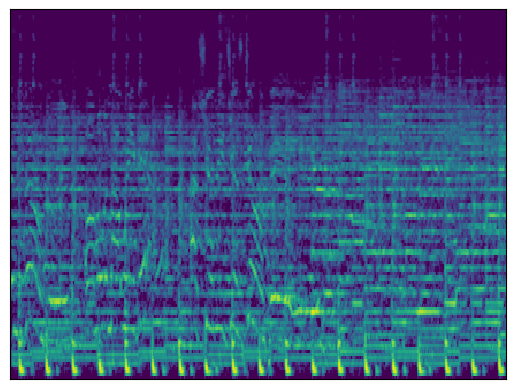

In [34]:
librosa.display.specshow(spec1, cmap='viridis')

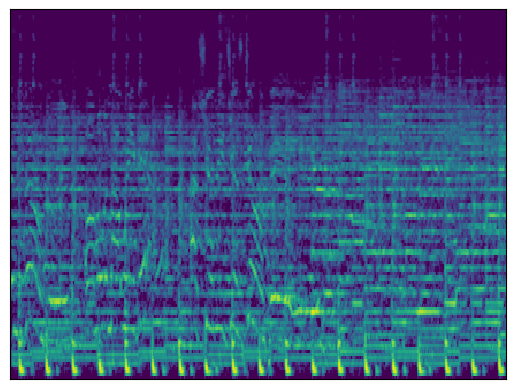

In [35]:
librosa.display.specshow(spec, cmap='viridis')

In [19]:
def spec_to_image(spec, eps=1e-6):
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - mean) / (std + eps)
  spec_min, spec_max = spec_norm.min(), spec_norm.max()
  spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
  spec_scaled = spec_scaled.astype(np.uint8)
  return spec_scaled

In [20]:
im = spec_to_image(spec, eps=1e-6)
im2 = spec_to_image(spec2, eps=1e-6)
print(im.shape)
print(im2.shape)

NameError: name 'spec' is not defined

In [86]:
# import numpy as np
# import pandas as pd
# from torch.utils.data import Dataset, DataLoader
# from tqdm import tqdm
# class GenerateDataloader(Dataset):
#   def __init__(self, categories, mp3_f):
#     self.mp3_f = mp3_f
#     self.data = []
#     self.labels = []
#     self.category2index={}
#     self.index2category={}
#     self.categories = categories
#     for i, category in enumerate(self.categories):
#       self.category2index[category]=i
#       self.index2category[i]=category
#     for ind in range(len(mp3_f)):
#       file_path=mp3_f[ind]
#       #print(file_path)
#       img = spec_to_image(get_melspectrogram_db_2(file_path))[np.newaxis,...]
#       if img.shape != (1, 128, 431):
#         print(img.shape, file_path)
      
#       self.data.append(spec_to_image(get_melspectrogram_db_2(file_path))[np.newaxis,...])
#       self.labels.append(file_path[10:13])
#   def __len__(self):
#     return len(self.data)
#   def __getitem__(self, idx):
#     return self.data[idx], self.labels[idx]



In [34]:
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
class GenerateDataloader(Dataset):
  def __init__(self, mp3_f, tipus, train_labels, dict_class):
    self.mp3_f = mp3_f
    self.data = []
    self.labels = []
    #self.category2index={}
    #self.index2category={}
    #self.categories = categories
    #for i, category in enumerate(self.categories):
    #  self.category2index[category]=i
    #  self.index2category[i]=category
    for ind in range(len(mp3_f)):
      file_path=mp3_f[ind]
      print(file_path)
      im=spec_to_image(get_melspectrogram_db_2(file_path))[np.newaxis,...]
      #new_im=np.resize(im, (128, 384, 1))
      self.data.append(im)

      if tipus=="train":
        #print(file_path[22:25])
        trackid=file_path[26:32]
        print(trackid)
        label_track=train_labels.loc[train_labels['track_id'] == int(trackid), 'genre'].values[0]
        label_track=dict_class[label_track]
        self.labels.append(int(label_track))
      else:
        #print(file_path[21:24])
        trackid=file_path[25:31]
        print(trackid)

        label_track=train_labels.loc[train_labels['track_id'] == int(trackid), 'genre'].values[0]
        label_track=dict_class[label_track]
        self.labels.append(int(label_track))

      #print(self.labels)
  def __len__(self):
    return len(self.data)
  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]

In [33]:
train_labels

,track_id,genre
0,2,Hip-Hop
1,5,Hip-Hop
2,10,Pop
3,140,Folk
4,141,Folk
...,...,...
7995,154308,Hip-Hop
7996,154309,Hip-Hop
7997,154413,Pop
7998,154414,Pop


In [36]:
train_data = GenerateDataloader(mp3_files_train,"train",train_labels,dict_class)

AUDIO_DIR_SPLIT/train/000/000204.mp3
000204
AUDIO_DIR_SPLIT/train/000/000615.mp3
000615
AUDIO_DIR_SPLIT/train/000/000777.mp3
000777
AUDIO_DIR_SPLIT/train/000/000203.mp3
000203
AUDIO_DIR_SPLIT/train/000/000459.mp3
000459
AUDIO_DIR_SPLIT/train/000/000182.mp3
000182
AUDIO_DIR_SPLIT/train/000/000715.mp3
000715
AUDIO_DIR_SPLIT/train/000/000213.mp3
000213
AUDIO_DIR_SPLIT/train/000/000193.mp3
000193
AUDIO_DIR_SPLIT/train/000/000676.mp3
000676
AUDIO_DIR_SPLIT/train/000/000141.mp3
000141
AUDIO_DIR_SPLIT/train/000/000997.mp3
000997
AUDIO_DIR_SPLIT/train/000/000821.mp3
000821
AUDIO_DIR_SPLIT/train/000/000822.mp3
000822
AUDIO_DIR_SPLIT/train/000/000625.mp3
000625
AUDIO_DIR_SPLIT/train/000/000210.mp3
000210
AUDIO_DIR_SPLIT/train/000/000621.mp3
000621
AUDIO_DIR_SPLIT/train/000/000010.mp3
000010
AUDIO_DIR_SPLIT/train/000/000897.mp3
000897
AUDIO_DIR_SPLIT/train/000/000706.mp3
000706
AUDIO_DIR_SPLIT/train/000/000705.mp3
000705
AUDIO_DIR_SPLIT/train/000/000197.mp3
000197
AUDIO_DIR_SPLIT/train/000/000256

[src/libmpg123/layer3.c:INT123_do_layer3():1844] error: dequantization failed!


011767
AUDIO_DIR_SPLIT/train/011/011770.mp3
011770
AUDIO_DIR_SPLIT/train/011/011264.mp3
011264
AUDIO_DIR_SPLIT/train/011/011780.mp3
011780
AUDIO_DIR_SPLIT/train/011/011919.mp3
011919
AUDIO_DIR_SPLIT/train/011/011777.mp3
011777
AUDIO_DIR_SPLIT/train/011/011200.mp3
011200
AUDIO_DIR_SPLIT/train/011/011942.mp3
011942
AUDIO_DIR_SPLIT/train/011/011544.mp3
011544
AUDIO_DIR_SPLIT/train/011/011763.mp3
011763
AUDIO_DIR_SPLIT/train/011/011771.mp3
011771
AUDIO_DIR_SPLIT/train/011/011199.mp3
011199
AUDIO_DIR_SPLIT/train/011/011239.mp3
011239
AUDIO_DIR_SPLIT/train/011/011793.mp3
011793
AUDIO_DIR_SPLIT/train/011/011788.mp3
011788
AUDIO_DIR_SPLIT/train/011/011237.mp3
011237
AUDIO_DIR_SPLIT/train/011/011261.mp3
011261
AUDIO_DIR_SPLIT/train/011/011206.mp3
011206
AUDIO_DIR_SPLIT/train/011/011234.mp3
011234
AUDIO_DIR_SPLIT/train/011/011794.mp3
011794
AUDIO_DIR_SPLIT/train/011/011306.mp3
011306
AUDIO_DIR_SPLIT/train/011/011791.mp3
011791
AUDIO_DIR_SPLIT/train/011/011505.mp3
011505
AUDIO_DIR_SPLIT/train/011

[src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!


021657
AUDIO_DIR_SPLIT/train/021/021996.mp3
021996
AUDIO_DIR_SPLIT/train/022/022095.mp3
022095
AUDIO_DIR_SPLIT/train/022/022480.mp3
022480
AUDIO_DIR_SPLIT/train/022/022348.mp3
022348
AUDIO_DIR_SPLIT/train/022/022001.mp3
022001
AUDIO_DIR_SPLIT/train/022/022481.mp3
022481
AUDIO_DIR_SPLIT/train/022/022479.mp3
022479
AUDIO_DIR_SPLIT/train/022/022476.mp3
022476
AUDIO_DIR_SPLIT/train/022/022296.mp3
022296
AUDIO_DIR_SPLIT/train/022/022478.mp3
022478
AUDIO_DIR_SPLIT/train/022/022091.mp3
022091
AUDIO_DIR_SPLIT/train/022/022088.mp3
022088
AUDIO_DIR_SPLIT/train/022/022472.mp3
022472
AUDIO_DIR_SPLIT/train/022/022315.mp3
022315
AUDIO_DIR_SPLIT/train/022/022473.mp3
022473
AUDIO_DIR_SPLIT/train/022/022150.mp3
022150
AUDIO_DIR_SPLIT/train/022/022093.mp3
022093
AUDIO_DIR_SPLIT/train/022/022097.mp3
022097
AUDIO_DIR_SPLIT/train/022/022000.mp3
022000
AUDIO_DIR_SPLIT/train/023/023355.mp3
023355
AUDIO_DIR_SPLIT/train/023/023037.mp3
023037
AUDIO_DIR_SPLIT/train/023/023039.mp3
023039
AUDIO_DIR_SPLIT/train/023

[src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!


029245
AUDIO_DIR_SPLIT/train/029/029971.mp3
029971
AUDIO_DIR_SPLIT/train/029/029740.mp3
029740
AUDIO_DIR_SPLIT/train/029/029744.mp3
029744
AUDIO_DIR_SPLIT/train/029/029745.mp3
029745
AUDIO_DIR_SPLIT/train/029/029738.mp3
029738
AUDIO_DIR_SPLIT/train/029/029739.mp3
029739
AUDIO_DIR_SPLIT/train/029/029742.mp3
029742
AUDIO_DIR_SPLIT/train/029/029719.mp3
029719
AUDIO_DIR_SPLIT/train/029/029041.mp3
029041
AUDIO_DIR_SPLIT/train/029/029037.mp3
029037
AUDIO_DIR_SPLIT/train/029/029465.mp3
029465
AUDIO_DIR_SPLIT/train/029/029961.mp3
029961
AUDIO_DIR_SPLIT/train/029/029530.mp3
029530
AUDIO_DIR_SPLIT/train/029/029720.mp3
029720
AUDIO_DIR_SPLIT/train/029/029807.mp3
029807
AUDIO_DIR_SPLIT/train/029/029528.mp3
029528
AUDIO_DIR_SPLIT/train/029/029718.mp3
029718
AUDIO_DIR_SPLIT/train/029/029039.mp3
029039
AUDIO_DIR_SPLIT/train/029/029271.mp3
029271
AUDIO_DIR_SPLIT/train/030/030050.mp3
030050
AUDIO_DIR_SPLIT/train/030/030487.mp3
030487
AUDIO_DIR_SPLIT/train/030/030519.mp3
030519
AUDIO_DIR_SPLIT/train/030

[src/libmpg123/layer3.c:INT123_do_layer3():1774] error: part2_3_length (3328) too large for available bit count (3240)


054753
AUDIO_DIR_SPLIT/train/054/054465.mp3
054465
AUDIO_DIR_SPLIT/train/054/054037.mp3
054037
AUDIO_DIR_SPLIT/train/054/054019.mp3
054019
AUDIO_DIR_SPLIT/train/054/054626.mp3
054626
AUDIO_DIR_SPLIT/train/054/054156.mp3
054156
AUDIO_DIR_SPLIT/train/054/054436.mp3
054436
AUDIO_DIR_SPLIT/train/054/054475.mp3
054475
AUDIO_DIR_SPLIT/train/054/054470.mp3
054470
AUDIO_DIR_SPLIT/train/054/054149.mp3
054149
AUDIO_DIR_SPLIT/train/054/054469.mp3
054469
AUDIO_DIR_SPLIT/train/054/054151.mp3
054151
AUDIO_DIR_SPLIT/train/054/054703.mp3
054703
AUDIO_DIR_SPLIT/train/054/054163.mp3
054163
AUDIO_DIR_SPLIT/train/054/054466.mp3
054466
AUDIO_DIR_SPLIT/train/054/054160.mp3
054160
AUDIO_DIR_SPLIT/train/054/054153.mp3
054153
AUDIO_DIR_SPLIT/train/054/054665.mp3
054665
AUDIO_DIR_SPLIT/train/054/054874.mp3
054874
AUDIO_DIR_SPLIT/train/054/054496.mp3
054496
AUDIO_DIR_SPLIT/train/054/054580.mp3
054580
AUDIO_DIR_SPLIT/train/054/054624.mp3
054624
AUDIO_DIR_SPLIT/train/054/054463.mp3
054463
AUDIO_DIR_SPLIT/train/054

/tmp/ipykernel_25794/3549135705.py:6: RuntimeWarning: invalid value encountered in divide
  spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)


057179
AUDIO_DIR_SPLIT/train/057/057691.mp3
057691
AUDIO_DIR_SPLIT/train/057/057437.mp3
057437
AUDIO_DIR_SPLIT/train/057/057178.mp3
057178
AUDIO_DIR_SPLIT/train/057/057360.mp3
057360
AUDIO_DIR_SPLIT/train/057/057663.mp3
057663
AUDIO_DIR_SPLIT/train/057/057639.mp3
057639
AUDIO_DIR_SPLIT/train/057/057627.mp3
057627
AUDIO_DIR_SPLIT/train/057/057371.mp3
057371
AUDIO_DIR_SPLIT/train/057/057626.mp3
057626
AUDIO_DIR_SPLIT/train/057/057164.mp3
057164
AUDIO_DIR_SPLIT/train/057/057442.mp3
057442
AUDIO_DIR_SPLIT/train/057/057177.mp3
057177
AUDIO_DIR_SPLIT/train/057/057540.mp3
057540
AUDIO_DIR_SPLIT/train/058/058213.mp3
058213
AUDIO_DIR_SPLIT/train/058/058474.mp3
058474
AUDIO_DIR_SPLIT/train/058/058116.mp3
058116
AUDIO_DIR_SPLIT/train/058/058052.mp3
058052
AUDIO_DIR_SPLIT/train/058/058212.mp3
058212
AUDIO_DIR_SPLIT/train/058/058115.mp3
058115
AUDIO_DIR_SPLIT/train/058/058333.mp3
058333
AUDIO_DIR_SPLIT/train/058/058540.mp3
058540
AUDIO_DIR_SPLIT/train/058/058169.mp3
058169
AUDIO_DIR_SPLIT/train/058

[src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!
Note: Illegal Audio-MPEG-Header 0x00000000 at offset 63168.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1365] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
/tmp/ipykernel_25794/941228387.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  x, sr = librosa.load(filename, sr=None, mono=True)
/home/alumne/anaconda3/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


098628
AUDIO_DIR_SPLIT/train/098/098577.mp3
098577
AUDIO_DIR_SPLIT/train/098/098585.mp3
098585
AUDIO_DIR_SPLIT/train/098/098228.mp3
098228
AUDIO_DIR_SPLIT/train/098/098579.mp3
098579
AUDIO_DIR_SPLIT/train/098/098667.mp3
098667
AUDIO_DIR_SPLIT/train/098/098549.mp3
098549
AUDIO_DIR_SPLIT/train/098/098580.mp3
098580
AUDIO_DIR_SPLIT/train/098/098574.mp3
098574
AUDIO_DIR_SPLIT/train/098/098623.mp3
098623
AUDIO_DIR_SPLIT/train/098/098548.mp3
098548
AUDIO_DIR_SPLIT/train/098/098205.mp3
098205
AUDIO_DIR_SPLIT/train/098/098348.mp3
098348
AUDIO_DIR_SPLIT/train/098/098565.mp3


Note: Illegal Audio-MPEG-Header 0x00000000 at offset 33361.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1365] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
/tmp/ipykernel_25794/941228387.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  x, sr = librosa.load(filename, sr=None, mono=True)
/home/alumne/anaconda3/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


098565
AUDIO_DIR_SPLIT/train/098/098573.mp3
098573
AUDIO_DIR_SPLIT/train/098/098625.mp3
098625
AUDIO_DIR_SPLIT/train/098/098669.mp3
098669
AUDIO_DIR_SPLIT/train/098/098578.mp3
098578
AUDIO_DIR_SPLIT/train/098/098624.mp3
098624
AUDIO_DIR_SPLIT/train/098/098554.mp3
098554
AUDIO_DIR_SPLIT/train/098/098339.mp3
098339
AUDIO_DIR_SPLIT/train/098/098349.mp3
098349
AUDIO_DIR_SPLIT/train/098/098227.mp3
098227
AUDIO_DIR_SPLIT/train/098/098626.mp3
098626
AUDIO_DIR_SPLIT/train/098/098302.mp3
098302
AUDIO_DIR_SPLIT/train/098/098237.mp3
098237
AUDIO_DIR_SPLIT/train/098/098620.mp3
098620
AUDIO_DIR_SPLIT/train/098/098553.mp3
098553
AUDIO_DIR_SPLIT/train/098/098581.mp3
098581
AUDIO_DIR_SPLIT/train/098/098680.mp3
098680
AUDIO_DIR_SPLIT/train/098/098619.mp3
098619
AUDIO_DIR_SPLIT/train/098/098627.mp3
098627
AUDIO_DIR_SPLIT/train/098/098025.mp3
098025
AUDIO_DIR_SPLIT/train/098/098681.mp3
098681
AUDIO_DIR_SPLIT/train/098/098251.mp3
098251
AUDIO_DIR_SPLIT/train/098/098618.mp3
098618
AUDIO_DIR_SPLIT/train/098

/tmp/ipykernel_25794/3549135705.py:6: RuntimeWarning: invalid value encountered in divide
  spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)


107187
AUDIO_DIR_SPLIT/train/107/107805.mp3
107805
AUDIO_DIR_SPLIT/train/107/107125.mp3
107125
AUDIO_DIR_SPLIT/train/107/107598.mp3
107598
AUDIO_DIR_SPLIT/train/107/107616.mp3
107616
AUDIO_DIR_SPLIT/train/107/107188.mp3
107188
AUDIO_DIR_SPLIT/train/107/107577.mp3
107577
AUDIO_DIR_SPLIT/train/107/107850.mp3
107850
AUDIO_DIR_SPLIT/train/107/107389.mp3
107389
AUDIO_DIR_SPLIT/train/107/107590.mp3
107590
AUDIO_DIR_SPLIT/train/107/107583.mp3
107583
AUDIO_DIR_SPLIT/train/107/107955.mp3
107955
AUDIO_DIR_SPLIT/train/107/107532.mp3
107532
AUDIO_DIR_SPLIT/train/107/107250.mp3
107250
AUDIO_DIR_SPLIT/train/107/107912.mp3
107912
AUDIO_DIR_SPLIT/train/108/108961.mp3
108961
AUDIO_DIR_SPLIT/train/108/108019.mp3
108019
AUDIO_DIR_SPLIT/train/108/108023.mp3
108023
AUDIO_DIR_SPLIT/train/108/108303.mp3
108303
AUDIO_DIR_SPLIT/train/108/108457.mp3
108457
AUDIO_DIR_SPLIT/train/108/108475.mp3
108475
AUDIO_DIR_SPLIT/train/108/108027.mp3
108027
AUDIO_DIR_SPLIT/train/108/108866.mp3
108866
AUDIO_DIR_SPLIT/train/108

In [35]:
test_data = GenerateDataloader(mp3_files_test,"test",train_labels,dict_class)

AUDIO_DIR_SPLIT/test/000/000368.mp3
000368
AUDIO_DIR_SPLIT/test/000/000540.mp3
000540
AUDIO_DIR_SPLIT/test/000/000212.mp3
000212
AUDIO_DIR_SPLIT/test/000/000853.mp3
000853
AUDIO_DIR_SPLIT/test/000/000667.mp3
000667
AUDIO_DIR_SPLIT/test/000/000695.mp3
000695
AUDIO_DIR_SPLIT/test/000/000211.mp3
000211
AUDIO_DIR_SPLIT/test/000/000707.mp3
000707
AUDIO_DIR_SPLIT/test/000/000005.mp3
000005
AUDIO_DIR_SPLIT/test/000/000194.mp3
000194
AUDIO_DIR_SPLIT/test/000/000704.mp3
000704
AUDIO_DIR_SPLIT/test/000/000716.mp3
000716
AUDIO_DIR_SPLIT/test/000/000714.mp3
000714
AUDIO_DIR_SPLIT/test/001/001687.mp3
001687
AUDIO_DIR_SPLIT/test/001/001443.mp3
001443
AUDIO_DIR_SPLIT/test/001/001040.mp3
001040
AUDIO_DIR_SPLIT/test/001/001642.mp3
001642
AUDIO_DIR_SPLIT/test/001/001924.mp3
001924
AUDIO_DIR_SPLIT/test/001/001649.mp3
001649
AUDIO_DIR_SPLIT/test/001/001929.mp3
001929
AUDIO_DIR_SPLIT/test/001/001196.mp3
001196
AUDIO_DIR_SPLIT/test/001/001661.mp3
001661
AUDIO_DIR_SPLIT/test/001/001733.mp3
001733
AUDIO_DIR_S

[src/libmpg123/layer3.c:INT123_do_layer3():1774] error: part2_3_length (3360) too large for available bit count (3240)


054568
AUDIO_DIR_SPLIT/test/054/054034.mp3
054034
AUDIO_DIR_SPLIT/test/054/054735.mp3
054735
AUDIO_DIR_SPLIT/test/054/054476.mp3
054476
AUDIO_DIR_SPLIT/test/054/054031.mp3
054031
AUDIO_DIR_SPLIT/test/054/054479.mp3
054479
AUDIO_DIR_SPLIT/test/054/054664.mp3
054664
AUDIO_DIR_SPLIT/test/054/054234.mp3
054234
AUDIO_DIR_SPLIT/test/055/055238.mp3
055238
AUDIO_DIR_SPLIT/test/055/055235.mp3
055235
AUDIO_DIR_SPLIT/test/055/055402.mp3
055402
AUDIO_DIR_SPLIT/test/055/055709.mp3
055709
AUDIO_DIR_SPLIT/test/055/055809.mp3
055809
AUDIO_DIR_SPLIT/test/055/055242.mp3
055242
AUDIO_DIR_SPLIT/test/055/055807.mp3
055807
AUDIO_DIR_SPLIT/test/055/055810.mp3
055810
AUDIO_DIR_SPLIT/test/055/055076.mp3
055076
AUDIO_DIR_SPLIT/test/055/055113.mp3
055113
AUDIO_DIR_SPLIT/test/055/055827.mp3
055827
AUDIO_DIR_SPLIT/test/055/055288.mp3
055288
AUDIO_DIR_SPLIT/test/055/055101.mp3
055101
AUDIO_DIR_SPLIT/test/055/055232.mp3
055232
AUDIO_DIR_SPLIT/test/055/055294.mp3
055294
AUDIO_DIR_SPLIT/test/056/056895.mp3
056895
AUDI

Note: Illegal Audio-MPEG-Header 0x00000000 at offset 22401.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1365] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
/tmp/ipykernel_25794/941228387.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  x, sr = librosa.load(filename, sr=None, mono=True)
/home/alumne/anaconda3/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


098567
AUDIO_DIR_SPLIT/test/098/098584.mp3
098584
AUDIO_DIR_SPLIT/test/098/098552.mp3
098552
AUDIO_DIR_SPLIT/test/098/098547.mp3
098547
AUDIO_DIR_SPLIT/test/098/098229.mp3
098229
AUDIO_DIR_SPLIT/test/098/098026.mp3
098026
AUDIO_DIR_SPLIT/test/098/098556.mp3
098556
AUDIO_DIR_SPLIT/test/098/098235.mp3
098235
AUDIO_DIR_SPLIT/test/098/098621.mp3
098621
AUDIO_DIR_SPLIT/test/098/098582.mp3
098582
AUDIO_DIR_SPLIT/test/098/098300.mp3
098300
AUDIO_DIR_SPLIT/test/098/098671.mp3
098671
AUDIO_DIR_SPLIT/test/098/098770.mp3
098770
AUDIO_DIR_SPLIT/test/098/098668.mp3
098668
AUDIO_DIR_SPLIT/test/099/099440.mp3
099440
AUDIO_DIR_SPLIT/test/099/099704.mp3
099704
AUDIO_DIR_SPLIT/test/099/099395.mp3
099395
AUDIO_DIR_SPLIT/test/099/099374.mp3
099374
AUDIO_DIR_SPLIT/test/099/099389.mp3
099389
AUDIO_DIR_SPLIT/test/099/099372.mp3
099372
AUDIO_DIR_SPLIT/test/099/099393.mp3
099393
AUDIO_DIR_SPLIT/test/099/099703.mp3
099703
AUDIO_DIR_SPLIT/test/099/099093.mp3
099093
AUDIO_DIR_SPLIT/test/100/100972.mp3
100972
AUDI

In [37]:
dataloaders_dict["train"] = DataLoader(train_data, batch_size=16, shuffle=True)

In [38]:
dataloaders_dict["val"] = DataLoader(test_data, batch_size=16, shuffle=True)

In [40]:
import pickle

# Save the dataloader
with open('dataloaderClasse.pkl', 'wb') as f:
    pickle.dump(dataloaders_dict, f)

Bad pipe message: %s [b'\xdf\xe1\xefHUI\xd0c>\xac\x1d\x0b\x99h\xd0;|? \xb1\xf8\x1c6s\x11\xd4(\x15\xb0\x14\x10\xa2^2\xf5\xa0\xb2ma\x15\xed\x0b\xb6RR\x104,\x1dS\x9b\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08\x06\x04\x01\x05\x01\x06\x01\x00+\x00\x03\x02\x03\x04\x00-\x00']
Bad pipe message: %s [b'?u\xcd\xf4R\xb1\xaf\xbboq\x8c\x03\xc3Nk\xb4j\x9b \x1e\xa3 \xdd\xed\xfd\x92O\x87\x1b\xbfLb\xa3\xf7\xf4\xc5\xca0\xe8\x13E\x0b\x95Qt\x8f|w\x8b\x03\xd6\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04', b'\x01\x02']
Bad pipe message: %s [b"(\xb8l\xcb\x07\\\x87\xa7;*Z\xe6\xef\n\x16\xf6+*\x00\x00\xa6\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa

In [48]:
# Load the saved dataloader
with open('dataloader.pkl', 'rb') as f:
    loaded_dataloader = pickle.load(f)

In [37]:
print(dataloaders_dict)

{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f9a2ea752a0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f9a2ea77bb0>}


In [38]:
print(loaded_dataloader)

NameError: name 'loaded_dataloader' is not defined